In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append(os.path.abspath('../src/'))
from ModelSelection import *
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

In [3]:
cup_df = pd.read_csv(
    '../data/ML-CUP23-TR.csv',
    index_col=0,
    comment='#',
    header=None,
    names=['feature_' + str(i+1) for i in range(10)] + ['target_' + str(i+1) for i in range(3)]
)

data_set = cup_df.values
len_data = len(data_set)
np.random.shuffle(data_set)

training_len = int(0.8*len_data)

training_set = data_set[:int(training_len)] # Training Set for KFold Cross Validation
test_set = data_set[int(training_len):] # Hold Out Test Set

TR_OUTPUT = 3
TR_INPUT = data_set.shape[1] - TR_OUTPUT

scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(training_set[:,:TR_INPUT])
scaler_out.fit(training_set[:,TR_INPUT:])

tr_normalized = np.empty((training_len, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(training_set[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(training_set[:,TR_INPUT:])

test_normalized = np.empty((len_data - training_len, TR_OUTPUT + TR_INPUT))
test_normalized[:,:TR_INPUT] = scaler_in.transform(test_set[:,:TR_INPUT])
test_normalized[:,TR_INPUT:] = scaler_out.transform(test_set[:,TR_INPUT:])

In [4]:
hidden_fun = 'ReLU'
output_fun = 'identity'
relu_l2 = create_stratified_topology([TR_INPUT,3, 3, 3,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*9 + [[output_fun, []]]*TR_OUTPUT)

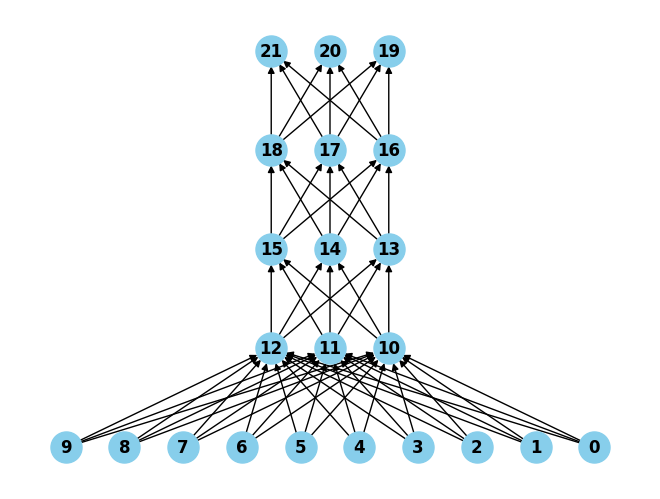

In [5]:
NeuralNetwork.display_topology(relu_l2)

In [6]:
MS = ModelSelection('../data/gs_data/test.csv')

MS.default_values['metrics'] = [ErrorFunctions.mean_euclidean_error, ErrorFunctions.mean_squared_error]
hyperparam_grid = {
    'adamax' : [True, False],
    'adamax_learning_rate' : [0.5, 0.3],
    'exp_decay_rate_1':[0.9, 0.99],
    'exp_decay_rate_2':[0.999],

    'lambda_tikhonov':[0.00001, 0.0001],
    'batch_size':[int(training_len/20), int(training_len/50)],
    'min_epochs': [100],
    'max_epochs':[800],

    'error_increase_tolerance':[0.00001],
    'patience':[5],
    'topology': [str(relu_l2)],
}

c1 = lambda x: x
MS.grid_searchKF(tr_normalized, hyperparam_grid, 3, 12, False)

Already done:  0
tot conf: 32
removed already done conf: 32
tot conf: 32
pid: 56881  started new kfold 1 / 11
pid: 56906  started new kfold 1 / 11
pid: 56941  started new kfold 1 / 11
pid: 56967  started new kfold 1 / 11


KeyboardInterrupt: 

In [6]:
MS = ModelSelection('../data/2l_relu_2.csv')
    
hyperparam_grid = {
    'learning_rate':[0.005, 0.02, 0.1, 0.2],
    'lr_decay_tau':[250],
    'adamax' : [True, False],
    'adamax_learning_rate' : [0.3, 0.5],
    'exp_decay_rate_1':[0.8, 0.7],
    'exp_decay_rate_2':[0.999],
    'alpha_momentum':[0.5, 0.75, 0.9],
    'lambda_tikhonov':[0.001, 0.0001],
    'batch_size':[int(training_len/20), int(training_len/40)],
    'min_epochs': [100],
    'max_epochs':[600],
    'metrics':[[ErrorFunctions.mean_euclidean_error, ErrorFunctions.mean_squared_error]],
    'error_increase_tolerance':[0.00001],
    'patience':[8],
    'topology': [str(relu_l2)],
}

c1 = lambda x: x
constr = {'adamax': (c1, ['learning_rate', 'alpha_momentum', 'lr_decay_tau'], ['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2'])}

#MS.grid_searchKF(tr_normalized, hyperparam_grid, constr, 3, 12, False)